<a href="https://colab.research.google.com/github/noel-odero/Formative3/blob/main/Part2_Bayesian_Probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Using Baye's Theorem, we answer the question : If a movie contains certain keyword, what's the probability it's a positive review?
- **Bayes' Theorem Formula**
  - ***P(Positive | keyword) = P(keyword | Positive) × P(Positive) / P(keyword)***

- In Plain English:
"The probability a review is positive GIVEN the keyword appears equals:

    - How often the keyword appears in positive reviews
   - Times the base rate of positive reviews
  - Divided by how often the keyword appears overall

In [ ]:
!pip install -q pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv("IMDB Dataset.csv")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample rows:")
print(df.head(30))



Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

Sample rows:
                                               review sentiment
0   One of the other reviewers has mentioned that ...  positive
1   A wonderful little production. <br /><br />The...  positive
2   I thought this was a wonderful way to spend ti...  positive
3   Basically there's a family where a little boy ...  negative
4   Petter Mattei's "Love in the Time of Money" is...  positive
5   Probably my all-time favorite movie, a story o...  positive
6   I sure would like to see a resurrection of a u...  positive
7   This show was an amazing, fresh & innovative i...  negative
8   Encouraged by the positive comments about this...  negative
9   If you like original gut wrenching laughter yo...  positive
10  Phil the Alien is one of those quirky films wh...  negative
11  I saw this movie when I was about 12 when it c...  negative
12  So im not a big fan of Boll's work but then ag...  negative
13  The cast played Shakespear

In [ ]:
# Data processing
missing = df.isnull().sum()
print(f"\nMissing values:")
print(missing)

# Converting to lower case for case-insensitive matching
df['review_lower'] = df['review'].str.lower()

# Standardize sentiment labels
df['sentiment'] = df['sentiment'].str.lower().str.strip()

# sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
total_reviews = len(df)
print(f"\nSentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    percentage = (count / total_reviews) * 100
    print(f"   {sentiment.capitalize()}: {count:,} ({percentage:}%)")


# Base rates
positive_reviews = len(df[df['sentiment'] == 'positive'])
negative_reviews = len(df[df['sentiment'] == 'negative'])

base_rate_positive = positive_reviews / total_reviews
base_rate_negative = negative_reviews / total_reviews

print(f"\nBase Rates:")
print(f"   P(Positive) = {base_rate_positive:} ({base_rate_positive*100:}%)")
print(f"   P(Negative) = {base_rate_negative:} ({base_rate_negative*100:}%)")



Missing values:
review          0
sentiment       0
review_lower    0
dtype: int64

Sentiment Distribution:
   Positive: 25,000 (50.0%)
   Negative: 25,000 (50.0%)

Base Rates:
   P(Positive) = 0.5 (50.0%)
   P(Negative) = 0.5 (50.0%)


In [ ]:
# Configuration

Positive_Keywords = ['wonderful', 'amazing', 'brilliant', 'masterpiece']
Negative_Keywords = ['terrible', 'awful', 'worst', 'frustrating', 'boring']
Calculate_For = 'positive'
print(f"\n Analysis Configuration:")
print(f"   Target sentiment: {Calculate_For.upper()}")
print(f"   Positive keywords: {Positive_Keywords}")
print(f"   Negative keywords: {Negative_Keywords}")


 Analysis Configuration:
   Target sentiment: POSITIVE
   Positive keywords: ['wonderful', 'amazing', 'brilliant', 'masterpiece']
   Negative keywords: ['terrible', 'awful', 'worst', 'frustrating', 'boring']


In [ ]:
# Keyword detection

def contains_keyword(text, keyword):

    pattern = r'\b' + re.escape(keyword.lower()) + r'\b'
    return bool(re.search(pattern, str(text).lower()))

all_keywords = Positive_Keywords + Negative_Keywords

print(f'\nSearching for {len(all_keywords)} keywords in {len(df):,} reviews...')


for keyword in all_keywords:
    column_name = f'has_{keyword}'

    # Apply keyword detection
    df[column_name] = df['review_lower'].apply(
        lambda x: contains_keyword(x, keyword)
    )

    # Count occurrences
    count = df[column_name].sum()
    percentage = (count / len(df)) * 100

    # Determine keyword type
    keyword_type = "POSITIVE" if keyword in Positive_Keywords else "NEGATIVE"

    print(f"   [{keyword_type}] '{keyword}': {count:,} occurrences ({percentage:.2f}%)")


    sentiment_reviews = df[df['sentiment'] == Calculate_For]




Searching for 9 keywords in 50,000 reviews...
   [POSITIVE] 'wonderful': 2,780 occurrences (5.56%)
   [POSITIVE] 'amazing': 2,158 occurrences (4.32%)
   [POSITIVE] 'brilliant': 2,088 occurrences (4.18%)
   [POSITIVE] 'masterpiece': 1,207 occurrences (2.41%)
   [NEGATIVE] 'terrible': 2,701 occurrences (5.40%)
   [NEGATIVE] 'awful': 2,883 occurrences (5.77%)
   [NEGATIVE] 'worst': 4,434 occurrences (8.87%)
   [NEGATIVE] 'frustrating': 173 occurrences (0.35%)
   [NEGATIVE] 'boring': 3,051 occurrences (6.10%)


In [ ]:
# Baye's Theorem Implementation

def calculate_bayes_probabilities(df, keyword, target_sentiment="positive"):
  """
    Formula:
    P(A|B) = P(B|A) × P(A) / P(B)

    In our case:
    P(Positive|keyword) = P(keyword|Positive) × P(Positive) / P(keyword)

    The probability that a review is Positive given that it contains the keyword
    equals the probability of the keyword given that the review is Positive,
    multiplied by the base rate (prior) of being Positive,
    and divided by the overall probability of seeing that keyword in any review.
  """

  keyword_col = f'has_{keyword}'

  # What is the probability that any random review is positive?

  prior = len(df[df['sentiment'] == target_sentiment]) / total_reviews

  # What is the probability of the keyword appearing in positive reviews?

  sentiment_reviews = df[df['sentiment'] == target_sentiment]
  num_sentiment_with_keyword = sentiment_reviews[keyword_col].sum()
  num_sentiment_reviews = len(sentiment_reviews)

  if num_sentiment_reviews > 0:
        likelihood = num_sentiment_with_keyword / num_sentiment_reviews
  else:
        likelihood = 0.0

  # What is the overal probability of the keyword appearing?

  num_keyword_total = df[keyword_col].sum()
  marginal = num_keyword_total / total_reviews


  # What is the probability of the positive sentiment give the keyword?

  if marginal > 0:
        posterior = (likelihood * prior) / marginal
  else:
        posterior = 0.0

  return {
        'keyword': keyword,
        'keyword_type': 'Positive' if keyword in Positive_Keywords else 'Negative',
        'prior': prior,
        'likelihood': likelihood,
        'marginal': marginal,
        'posterior': posterior,
        'n_sentiment': num_sentiment_reviews,
        'n_keyword': num_keyword_total,
        'n_sentiment_with_keyword': num_sentiment_with_keyword
    }


print(calculate_bayes_probabilities(df, 'amazing', target_sentiment='positive'))


{'keyword': 'amazing', 'keyword_type': 'Positive', 'prior': 0.5, 'likelihood': np.float64(0.06716), 'marginal': np.float64(0.04316), 'posterior': np.float64(0.778035217794254), 'n_sentiment': 25000, 'n_keyword': np.int64(2158), 'n_sentiment_with_keyword': np.int64(1679)}


In [ ]:
# Compute for all keywords
results = [calculate_bayes_probabilities(df, kw, target_sentiment=Calculate_For) for kw in all_keywords]

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df[['prior', 'likelihood', 'marginal', 'posterior']] = results_df[['prior', 'likelihood', 'marginal', 'posterior']].round(4)

# Display as markdown-like table
print("\nBayesian Probability Table:")
print(results_df[['keyword', 'keyword_type', 'prior', 'likelihood', 'marginal', 'posterior']].to_string(index=False))



Bayesian Probability Table:
    keyword keyword_type  prior  likelihood  marginal  posterior
  wonderful     Positive    0.5      0.0903    0.0556     0.8122
    amazing     Positive    0.5      0.0672    0.0432     0.7780
  brilliant     Positive    0.5      0.0635    0.0418     0.7601
masterpiece     Positive    0.5      0.0351    0.0241     0.7274
   terrible     Negative    0.5      0.0153    0.0540     0.1418
      awful     Negative    0.5      0.0114    0.0577     0.0985
      worst     Negative    0.5      0.0164    0.0887     0.0927
frustrating     Negative    0.5      0.0024    0.0035     0.3526
     boring     Negative    0.5      0.0236    0.0610     0.1937


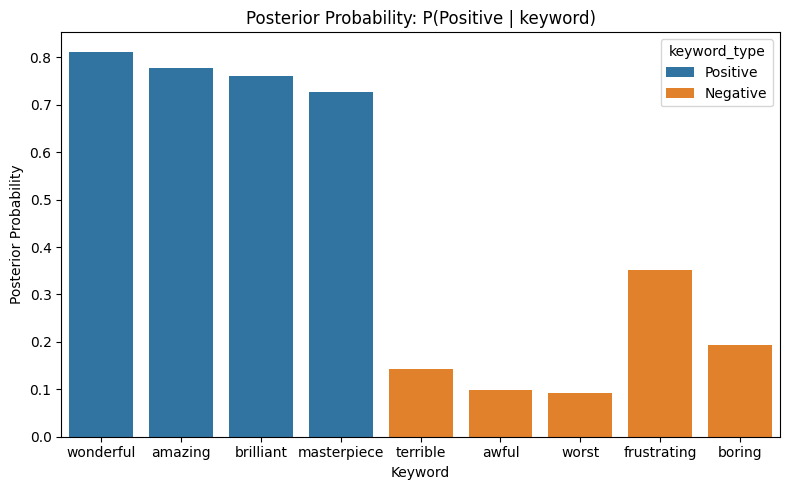

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='keyword', y='posterior', hue='keyword_type', data=results_df)
plt.title(f"Posterior Probability: P({Calculate_For.capitalize()} | keyword)")
plt.xlabel("Keyword")
plt.ylabel("Posterior Probability")
plt.tight_layout()
plt.show()

In [ ]:
for _, row in results_df.iterrows():
    print(f"If a review contains '{row['keyword']}', the probability it's {Calculate_For} is {row['posterior']:.2%}.")


If a review contains 'wonderful', the probability it's positive is 81.22%.
If a review contains 'amazing', the probability it's positive is 77.80%.
If a review contains 'brilliant', the probability it's positive is 76.01%.
If a review contains 'masterpiece', the probability it's positive is 72.74%.
If a review contains 'terrible', the probability it's positive is 14.18%.
If a review contains 'awful', the probability it's positive is 9.85%.
If a review contains 'worst', the probability it's positive is 9.27%.
If a review contains 'frustrating', the probability it's positive is 35.26%.
If a review contains 'boring', the probability it's positive is 19.37%.
